# Contaminate mock with Photometric weight

**author:** Edmond Chaussidon (CEA Saclay)

**mail:** edmond.chaussidon@cea.fr

This notebook explains how to contaminate mocks (and test the efficiency of the method) from photometric weight. The last part needs ``pycorr`` and ``pypower``. 

You need an acces to `/global/cfs/cdirs/desi/`.

In [1]:
import os
import logging
import fitsio

from regressis import PhotoWeight
from regressis.mocks import create_flag_imaging_systematic
from regressis.utils import setup_logging, setup_mplstyle

setup_logging()
setup_mplstyle() # On NERSC, you may need to load tex with `module load texlive/2019`

logger = logging.getLogger("Notebook")

data_dir = '../regressis/tests/test_data'

In [2]:
%matplotlib inline 

In [3]:
# I/O functions:
def _desi_mock_filename(tracer='LRG', ph=0):
    """Collect the name of DESI Mocks in NERSC."""
    mock_dir='/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/'
    z_dic={'LRG':0.8,'ELG':1.1,'QSO':1.4}
    fname=f'{mock_dir}{tracer}/z{z_dic[tracer]:5.3f}/cutsky_{tracer}_z{z_dic[tracer]:5.3f}_AbacusSummit_base_c000_ph{ph:003d}.fits'
    return fname


def _save_flag(flag, colname, savename):
    """Save flag with a specif colname in .fits file called savename"""
    fits = fitsio.FITS(savename, 'rw', clobber=True) #clobber to overwrite file
    if len(flag) == 1:
        to_save = np.array(flag[0], dtype=[(colname[0], 'bool')])
        fits.write(to_save)
    elif len(flag) == 2:
        fits.write(flag, names=colname)
    fits.close()
    logger.info(f'WRITE flag in {savename}')

-----

## Load data and apply contamination:

For this example, we will use the SV3 LRG target density (with **only** standard maskbit from the Imaging legacy survey) to estimate the imaging systematic effects. This target selection is known to be contaminated by stars near the galactic plane. Additional masks (around Gaia stars) were developped by Rongpu Zhou to reduce stellar contamination. That is why, the clustering computed at this end does not match the clustering computed in Zhou et al. 2020. 

In [4]:
version = 'SV3'
tracer = 'LRG'

# Load photometric weight
wsys = PhotoWeight.load(os.path.join(data_dir, f'{version}_{tracer}_imaging_weight_256.npy'))

# Load mock
mock_name = _desi_mock_filename(tracer=tracer, ph=0)
logger.info(f"Read Mock: {mock_name}")
mock = fitsio.FITS(mock_name)[1].read()

# Load high density mock flag
flag_dir = mock_name + '_flags'
logger.info(f"Read Mock flag: {os.path.join(flag_dir, 'pnz.fits')}")
sel_pnz = fitsio.FITS(os.path.join(flag_dir, 'pnz.fits'))[1]['pnz'].read()

[000000.03] 22-04-26 03:07  PhotoWeight          INFO     Load PhotoWeight class from ../regressis/tests/test_data/SV3_LRG_imaging_weight_256.npy
[000000.03] 22-04-26 03:07  Notebook             INFO     Read Mock: /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
[000003.60] 22-04-26 03:08  Notebook             INFO     Read Mock flag: /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits_flags/pnz.fits


----

**Implementation:** Starting from a mock with a higher density than the expected density from data, contamination is done removing objects in each pixel. The quantity of objects to remove is defined by $A$ in $N_{mocks} - A = N_{obs}$. 

Normalizing A by the density of objects in Mocks we have: $A_{norm} = A / N_{mocks}$ and $A_{norm} = 1 - \dfrac{N_{obs}}{N_{mocks}} = 1 - \dfrac{1}{w_{sys}f}$ where $f$ is the ratio between $N_{mocks}$ and $N_{expected}$. Take care $N_{expected}$ is not the same in each photometric footprint. $N_{expected}$ can be estimated from the data !

-----

In [5]:
# Compute flags to build contaminated mock
# Fix the seed for reproductibility
is_in_wsys_footprint, is_for_wsys_cont, pix_number = create_flag_imaging_systematic(mock, sel_pnz, wsys, use_real_density=True, show=False, savedir=None, seed=123)

if False:
    # Save flags in the flag directory (modify '' by flag_dir in os.path.join()
    save_flag([pix_number, is_in_wsys_footprint, is_for_wsys_cont, wsys(pix_number)], ['HPX', 'IS_IN_WSYS', 'IS_FOR_CONT', 'WSYS'], os.path.join('', 'photo_contamination.fits'))

[000007.31] 22-04-26 03:08  Mocks                INFO     Compute the healpix number at nside=256 for each object in the mock
[000024.12] 22-04-26 03:08  Mocks                INFO     Use the real density from PhotoWeight class
[000030.10] 22-04-26 03:08  Mocks                INFO     We remove 76.92% of the objects in the mocks which are in wsys footprint !


-----

## Testing the method !

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from regressis import PhotometricDataFrame, Regression, DR9Footprint
from regressis.utils import build_healpix_map
from regressis.plot import plot_moll
from regressis.systematics import plot_systematic_from_map

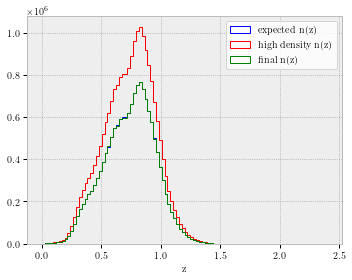

In [7]:
# flag for expected n(z) mock
sel_nz = mock['STATUS'] & 2**0 != 0

plt.figure(figsize=(5, 4))
plt.hist(mock['Z'][sel_nz&is_in_wsys_footprint], histtype='step', bins=100, range=(0.0, 2.4), label='expected n(z)')
plt.hist(mock['Z'][sel_pnz&is_in_wsys_footprint], histtype='step', bins=100, range=(0.0, 2.4), label='high density n(z)')
plt.hist(mock['Z'][is_for_wsys_cont], histtype='step', bins=100, range=(0.0, 2.4), label='final n(z)')
plt.legend()
plt.xlabel('z')
plt.tight_layout()
plt.show()

In [8]:
# Build healpix map:
expected_mock_map = build_healpix_map(256, mock['RA'], mock['DEC'], precomputed_pix=pix_number, sel=sel_nz, in_deg2=True)
cont_mock_map = build_healpix_map(256, mock['RA'], mock['DEC'], precomputed_pix=pix_number, sel=is_for_wsys_cont, in_deg2=True)

In [9]:
# Compute photometric weight from the contaminated mock (cf photometric_mitigation_* notebook for usefull comments):
wsys_already_computed = True # usefull to avoid to spend time for this computation if already computed

version, tracer, suffix_tracer = 'MOCKS', 'LRG', '0'

# Load DR9 footprint:
dr9_footprint = DR9Footprint(256, mask_lmc=False, clear_south=True, mask_around_des=True, cut_desi=False)

# Set parameters for the dataframe:
params = dict()
params['data_dir'] = '../regressis/tests/test_data'
params['output_dir'] = None
params['regions'] = ['North', 'South', 'Des']

# Build PhotometricDataFrame class:
dataframe = PhotometricDataFrame(version, tracer, dr9_footprint, suffix_tracer, **params)

# Load features from params['data_dir']:
logger.info('Features')
dataframe.set_features() 

# Load default fracarea (FRACAREA_12290 from features):
logger.info('Targets')
dataframe.set_targets(targets=cont_mock_map)

# Select which pixels will be kept for the training and compute the normalized density on each selected params['regions']:
logger.info('Build')
dataframe.build(cut_fracarea=True)

if wsys_already_computed:
    # Load computed weight (useful if you don't want to recompute all the time the weight)
    wsys_new = PhotoWeight.load(f'{dataframe.version}_{dataframe.tracer}{dataframe.suffix_tracer}_imaging_weight_256.npy')
else:
    # Run regression and collect computed weight
    regression = Regression(dataframe, regressor='RF', use_kfold=True, n_jobs=6, seed=123)
    wsys_new = regression.get_weight(save=True, savedir='')

[000037.16] 22-04-26 03:08  Footprint            INFO     Load DR9 footprint with mask_lmc=False, clear_south=True, mask_around_des=True and cut_desi=False
[000037.18] 22-04-26 03:08  DataFrame            INFO     version: MOCKS -- tracer: LRG -- regions: ['North', 'South', 'Des']
[000037.19] 22-04-26 03:08  Notebook             INFO     Features
[000037.19] 22-04-26 03:08  DataFrame            INFO     Read ../regressis/tests/test_data/pixweight-dr9-256.fits
[000037.89] 22-04-26 03:08  DataFrame            INFO     Read ../regressis/tests/test_data/sagittarius_stream_256.npy
[000037.97] 22-04-26 03:08  DataFrame            INFO     Sanity check: number of NaNs in features: 0
[000037.97] 22-04-26 03:08  Notebook             INFO     Targets
[000037.97] 22-04-26 03:08  DataFrame            INFO     Do not find corresponding fracarea map --> use FRACAREA_12290 as default fracarea
[000037.97] 22-04-26 03:08  DataFrame            INFO     Read ../regressis/tests/test_data/pixweight-dr9-256

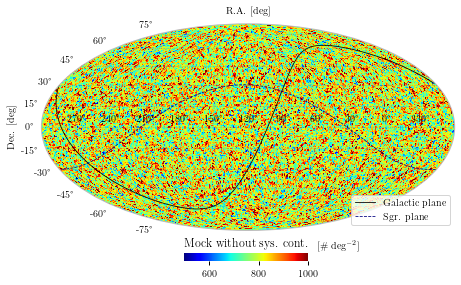

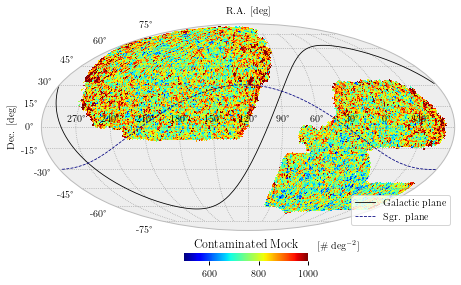

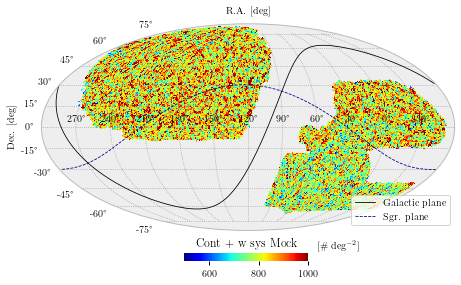

In [10]:
# Impact of the correction on the target distribution on the sky. After applying the weight, the density in DES region is lower as obserbed in the target density

to_plot = expected_mock_map.copy()
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Mock without sys. cont.')

to_plot = cont_mock_map.copy()
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Contaminated Mock')

to_plot = cont_mock_map.copy() * wsys_new.map
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Cont + w sys Mock')

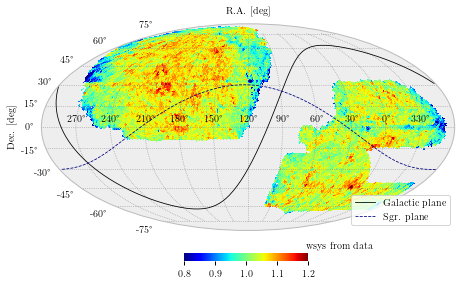

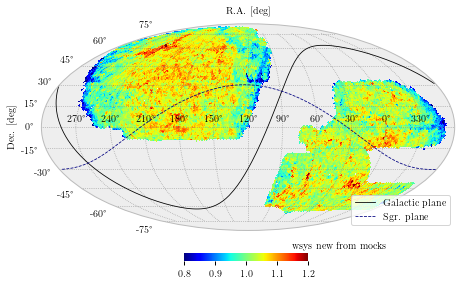

In [11]:
# We compare the weight from data used to contaminated mock and the computed weight from Mock
plot_moll(hp.ud_grade(wsys.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=0.8, max=1.2, figsize=(7, 5), label='wsys from data')
plot_moll(hp.ud_grade(wsys_new.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=0.8, max=1.2, figsize=(7, 5), label='wsys new from mocks')

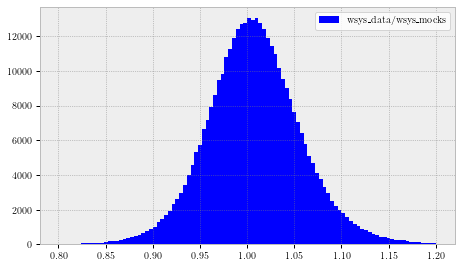

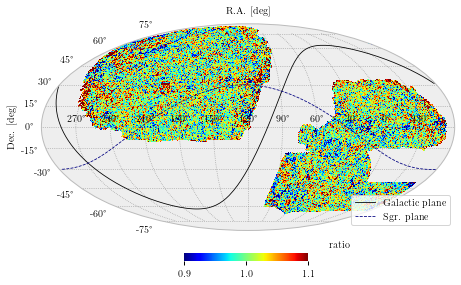

In [12]:
# Compare imaging systematic weight estimated from the data and those estimated from mocks:
ratio = wsys.map / wsys_new.map 

plt.figure(figsize=(6.55, 4))
plt.hist(ratio, bins=100, range=(0.8, 1.2), label='wsys_data/wsys_mocks')
plt.legend()
plt.show()

plot_moll(ratio, galactic_plane=True, sgr_plane=True, min=0.9, max=1.1, figsize=(7, 5), label='ratio')


The systematic plots computed from real data are available for LRG in img directory

[000049.70] 22-04-26 03:08  Systematics          INFO     Work with North
[000050.70] 22-04-26 03:08  Systematics          INFO     Keep only pixels with fracarea > 0
[000050.70] 22-04-26 03:08  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


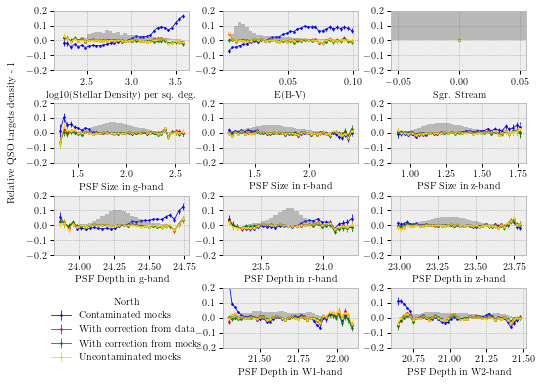

[000054.93] 22-04-26 03:08  Systematics          INFO     Work with South
[000055.89] 22-04-26 03:08  Systematics          INFO     Keep only pixels with fracarea > 0
[000055.90] 22-04-26 03:08  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


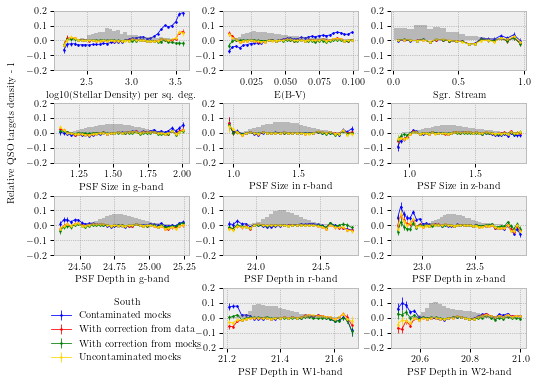

[000061.01] 22-04-26 03:08  Systematics          INFO     Work with Des
[000061.96] 22-04-26 03:08  Systematics          INFO     Keep only pixels with fracarea > 0
[000061.97] 22-04-26 03:08  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


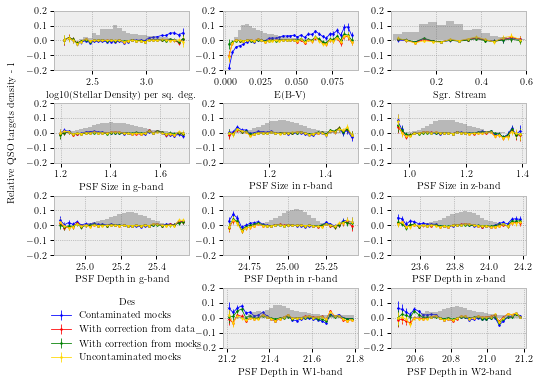

In [13]:
# Systematic plots

print("\nThe systematic plots computed from real data are available for LRG in img directory\n")

with np.errstate(invalid='ignore'): # avoid error with nan values 
    plot_systematic_from_map([dataframe.targets, dataframe.targets*wsys.map, dataframe.targets*wsys_new.map, expected_mock_map], 
                             ['Contaminated mocks', 'With correction from data', 'With correction from mocks', 'Uncontaminated mocks'], 
                              dataframe.fracarea, dataframe.footprint, dataframe.features, dataframe.regions,
                              ax_lim=0.2, legend_title=True, hist_legend=False, cut_fracarea=True, limits_fracarea=(0.9, 1.1), show=True, save=False, savedir='')

[000066.11] 22-04-26 03:09  Systematics          INFO     Work with North
[000067.09] 22-04-26 03:09  Systematics          INFO     Keep only pixels with fracarea > 0
[000067.09] 22-04-26 03:09  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


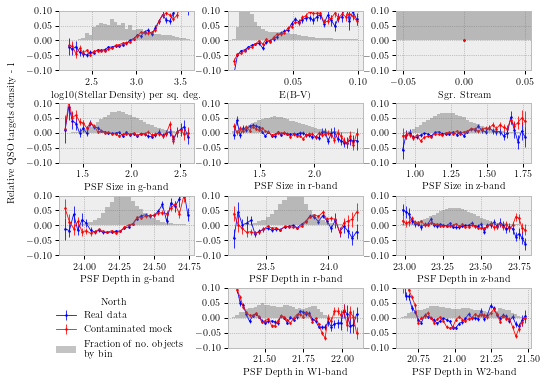

[000070.29] 22-04-26 03:09  Systematics          INFO     Work with South
[000071.24] 22-04-26 03:09  Systematics          INFO     Keep only pixels with fracarea > 0
[000071.24] 22-04-26 03:09  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


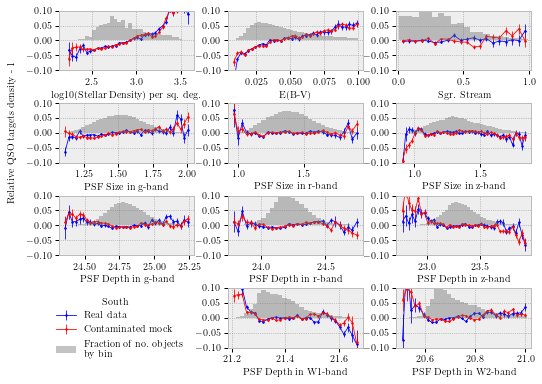

[000075.24] 22-04-26 03:09  Systematics          INFO     Work with Des
[000076.15] 22-04-26 03:09  Systematics          INFO     Keep only pixels with fracarea > 0
[000076.16] 22-04-26 03:09  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


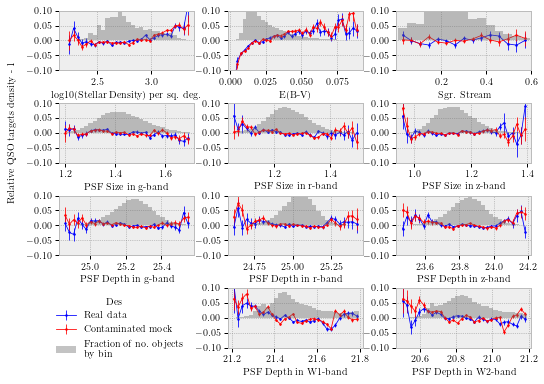

In [14]:
# Compare real data to contaminated mock:

data_map = np.load(os.path.join(data_dir, 'SV3_LRG_256.npy'))

with np.errstate(invalid='ignore'): # avoid error with nan values 
    plot_systematic_from_map([data_map, dataframe.targets], 
                             ['Real data', 'Contaminated mock'], 
                              dataframe.fracarea, dataframe.footprint, dataframe.features, dataframe.regions,
                              ax_lim=0.1, cut_fracarea=True, limits_fracarea=(0.9, 1.1), legend_title=True, show=True, save=False)

-----

## Compute angular correlation function:

**Requirements:** ``pycorr`` (https://github.com/cosmodesi/pycorr) (installation is straight forward following the doc.)

In [15]:
from pycorr import TwoPointCorrelationFunction, LandySzalayTwoPointEstimator, KMeansSubsampler

In [16]:
def get_ra_dec(nside):
    ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=True, lonlat=True)
    return ra, dec

def compute_theoritical_error(result):
    Gp = result.R1R2.normalized_wcounts()
    ND = result.D1D2.positions1[0].size
    xi_v = np.nansum(Gp*result.corr) # le 
    d = (result.corr + 1.) / (xi_v + 1.) # eq. 48
    p = 2./(Gp * ND * (ND - 1)) # eq. 43
    return d * p**0.5

def compute_angular_correlation(pix_data, pix_randoms, ra_pix, dec_pix, pix_selected, suffixe, 
                                sys_weight_map=None, edges=None, n_jackkniffe=20,
                                return_result=False, return_plot=False, save_result=False):
    """
    Remark: 
        * Error estimation with Jackknife increase the computation speed (TwoPointCorrelationFunction step) by a factor higher than ~2.
        * In the case of Target LRG in DES n_jackknife = 5 give already correct estimation of the error ! (obvisouly n_jackknife will depends on the region)
    """
    if edges is None:
        logger.info('Use default edges: np.geomspace(1e-1, 10, 25)')
        edges = np.geomspace(1e-1, 10, 25)
        
    if sys_weight_map is not None:
        logger.info('Apply systematic weights')
        pix_data_weight = pix_data*sys_weight_map
    else:
        pix_data_weight = pix_data
        
    if n_jackkniffe is not None:
        # for the Jackniffe errors: Initialize KMeansSubsampler with data or random positions -> should have no impact.
        subsampler = KMeansSubsampler(mode='angular', positions=[ra_pix[pix_selected], dec_pix[pix_selected]], nsamples=n_jackkniffe, nside=512, random_state=42, position_type='rd')
        data_labels = randoms_labels = subsampler.label([ra_pix[pix_selected], dec_pix[pix_selected]])
    else:
        data_labels = randoms_labels = None
        
    import time
    start = time.time()    
    result = TwoPointCorrelationFunction('theta', edges, 
                                         data_positions1=[ra_pix[pix_selected], dec_pix[pix_selected]], 
                                         data_weights1=pix_data_weight[pix_selected], 
                                         data_samples1=data_labels,
                                         randoms_positions1=[ra_pix[pix_selected], dec_pix[pix_selected]], 
                                         randoms_weights1=pix_randoms[pix_selected], 
                                         randoms_samples1=randoms_labels,
                                         engine='corrfunc', isa='fastest', nthreads=48)
    logger.info(f"It takes: {time.time()-start}")
    
    if save_result:
        output = f'PYCORR/LRG_{suffixe}.npy'
        result.save(output)
    
    if return_result:
        return result
    
    if return_plot:
        if n_jackkniffe is None:
            return result.sep, result.corr, compute_theoritical_error(result)
        else: 
            return result.sep, result.corr, np.diag(result.cov())**0.5

In [17]:
nside_corr = 256

# footprint at correct nside
DR9 = DR9Footprint(nside=nside_corr, mask_lmc=False, clear_south=True, mask_around_des=True, cut_desi=False)

# build ra, dec position of the each pixel
ra_pix, dec_pix = get_ra_dec(nside_corr)

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
logger.info(f'Load randoms: {randoms_path}')
randoms = fitsio.FITS(randoms_path)[1].read()
# keep only randoms with correct n(z) distribution (need for power spectrum measurement)
randoms = randoms[randoms['STATUS'] & 2**0 != 0]
logger.info('Build random healpix map...')
randoms_pix, randoms_pix_number = build_healpix_map(nside_corr, randoms['RA'], randoms['DEC'], return_pix=True)

logger.info('Build uncontaminated mock healpix map...')
mock_uncont = mock[sel_nz&is_in_wsys_footprint]
mock_uncont_pix, mock_uncont_pix_number = build_healpix_map(nside_corr, mock_uncont['RA'], mock_uncont['DEC'], return_pix=True)
logger.info('Build contaminated mock healpix map...')
mock_cont = mock[is_for_wsys_cont]
mock_cont_pix, mock_cont_pix_number = build_healpix_map(nside_corr, mock_cont['RA'], mock_cont['DEC'], return_pix=True)

wsys_pix = hp.ud_grade(wsys_new.map, nside_corr, order_in='nested')
wsys_for_cont_pix = hp.ud_grade(wsys.map, nside_corr, order_in='nested')

[000079.45] 22-04-26 03:09  Footprint            INFO     Load DR9 footprint with mask_lmc=False, clear_south=True, mask_around_des=True and cut_desi=False
[000079.52] 22-04-26 03:09  Notebook             INFO     Load randoms: /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits
[000087.37] 22-04-26 03:09  Notebook             INFO     Build random healpix map...
[000090.51] 22-04-26 03:09  Notebook             INFO     Build uncontaminated mock healpix map...
[000094.28] 22-04-26 03:09  Notebook             INFO     Build contaminated mock healpix map...


[000098.31] 22-04-26 03:09  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000104.56] 22-04-26 03:09  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000104.56] 22-04-26 03:09  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000115.87] 22-04-26 03:09  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.
[000134.05] 22-04-26 03:10  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.
[000144.76] 22-04-26 03:10  Notebook             INFO     It takes: 40.20278453826904
[000145.89] 22-04-26 03:10  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000161.98] 22-04-26 03:10  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000162.04] 22-04-26 03:10  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000172.97] 22-04-26 03:10  

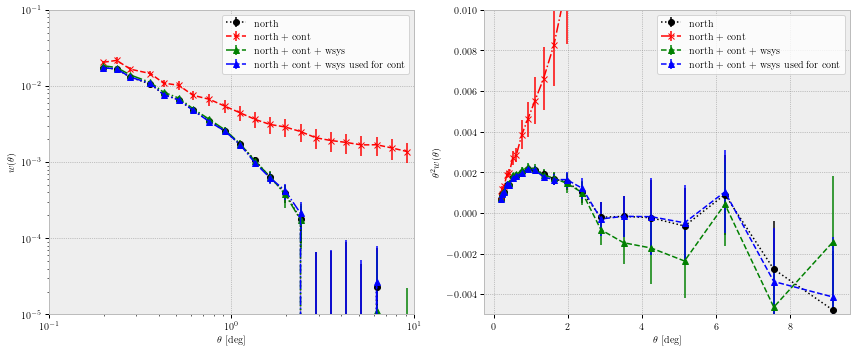

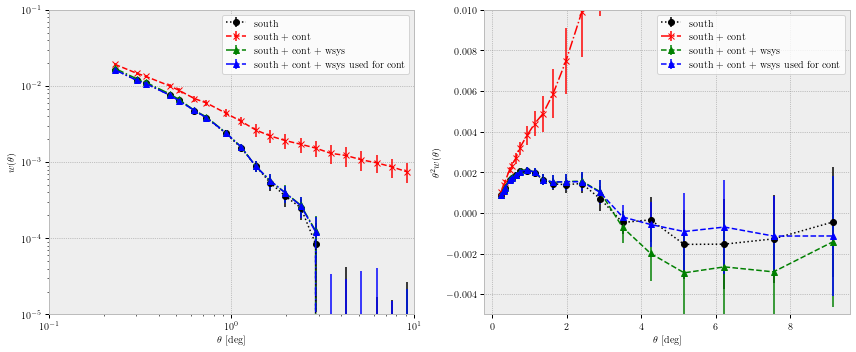

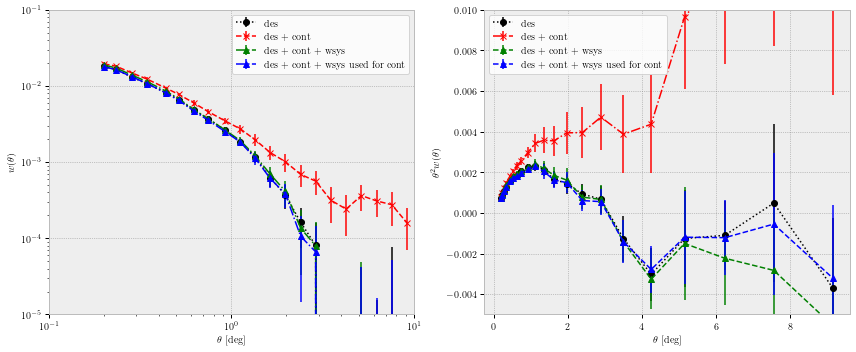

In [18]:
regions = ['north', 'south', 'des']

for i, region in enumerate(regions):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    theta, w, err_w = compute_angular_correlation(mock_uncont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=None, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='o', ls=':', c='black', label=region)
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='o', ls=':', c='black', label=region)  
    
    theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=None, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='x', ls='--', c='red', label=region+' + cont')
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='x', ls='-.', c='red', label=region+' + cont')   
    
    theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=wsys_pix, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='^', ls='-.', c='green', label=region+' + cont + wsys')
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='^', ls='--', c='green', label=region+' + cont + wsys')  
    
    theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=wsys_for_cont_pix, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='^', ls='-.', c='blue', label=region+' + cont + wsys used for cont')
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='^', ls='--', c='blue', label=region+' + cont + wsys used for cont')
    
    ax = axs[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-1, 1e1)
    ax.set_ylim(1e-5, 1e-1)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$w(\theta)$')
    ax.legend()

    ax = axs[1]
    ax.set_ylim(-0.005, 0.01)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\theta^2 w(\theta)$')
    ax.legend()

    fig.tight_layout()

plt.show()

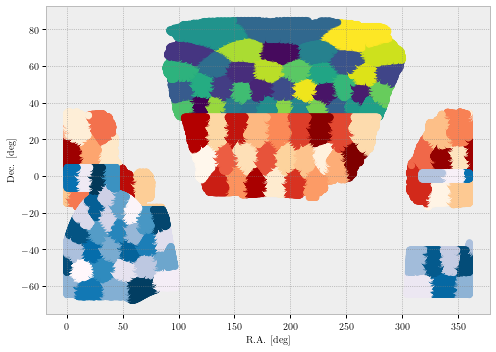

In [19]:
# Draw the patch for jackkniffe error estimation:

regions = ['north', 'south', 'des']
cmap = ['viridis', 'OrRd', 'PuBu'] 
plt.figure(figsize=(7, 5))

for i, region in enumerate(regions):
    subsampler = KMeansSubsampler(mode='angular', positions=[ra_pix[DR9(region)], dec_pix[DR9(region)]], nsamples=40, nside=512, random_state=42, position_type='rd')

    plt.scatter(ra_pix[DR9(region)], dec_pix[DR9(region)], c=subsampler.label([ra_pix[DR9(region)], dec_pix[DR9(region)]]), cmap=cmap[i])
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')

plt.tight_layout()
plt.show()

[000946.51] 22-04-26 03:23  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000947.75] 22-04-26 03:23  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000947.75] 22-04-26 03:23  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000950.45] 22-04-26 03:23  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.
[000955.65] 22-04-26 03:23  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.
[000958.35] 22-04-26 03:23  Notebook             INFO     It takes: 10.599537134170532
[000959.40] 22-04-26 03:23  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000963.35] 22-04-26 03:23  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000963.35] 22-04-26 03:23  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000967.15] 22-04-26 03:24 

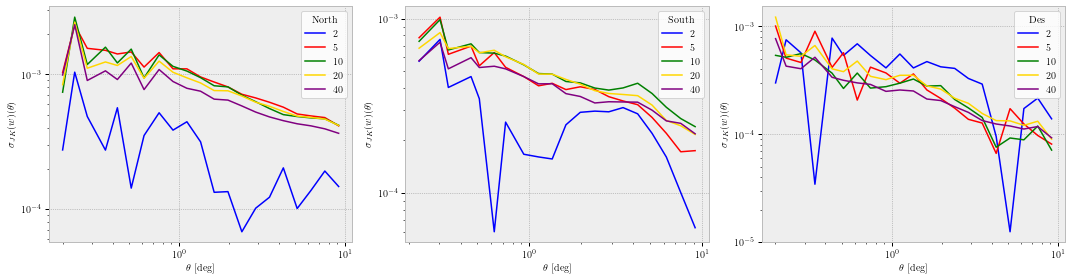

In [20]:
# Plot jackknife error estimation as a function of number of jackkniffe regions used:

regions = ['North', 'South', 'Des']

fig, axs = plt.subplots(1, len(regions), figsize=(5*len(regions), 4))

for i, region in enumerate(regions):
    ax = axs[i]
    
    for n_jack in [2, 5, 10, 20, 40]:
        theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, return_plot=True, n_jackkniffe=n_jack)
        ax.plot(theta, err_w, label=n_jack)
    
    ax.legend(title=region)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\sigma_{JK}(w)(\theta)$')
    
plt.tight_layout()
plt.savefig('jackniffe_error.pdf')
plt.show()

---------

## Compute power spectrum:

**Requierement**: ``pypower`` (https://github.com/adematti/pypower) and ``cosmoprimo`` (https://github.com/cosmodesi/cosmoprimo)

In [21]:
from pypower import CatalogFFTPower

# Set cosmology to transform redshift to distance
from cosmoprimo.fiducial import DESI
distance = DESI(engine='class').comoving_radial_distance  

In [22]:
from wrapper import time_measurement

@time_measurement
def compute_power(data, randoms, data_weights=None, randoms_weights=None, ells=(0, 2, 4), edges=None, return_plot=False):
    if edges is None:
        logger.info('Use default edges: np.linspace(0, 0.3, 81)')
        edges = np.linspace(0, 0.3, 81)
    
    # set data weights
    if data_weights is None:
        data_weights = np.ones(data['RA'].size)
    
    # set randoms weights
    if randoms_weights is None:
        randoms_weights = np.ones(randoms['RA'].size)
    
    result = CatalogFFTPower(data_positions1=[data['RA'], data['DEC'], distance(data['Z'])], data_weights1=data_weights,
                             randoms_positions1=[randoms['RA'], randoms['DEC'], distance(randoms['Z'])], randoms_weights1=randoms_weights,
                             edges=edges, ells=ells, interlacing=2, boxsize=None, boxpad=4, nmesh=512, resampler='tsc',
                             los=None, position_type='rdd', mpiroot=0)
    if return_plot:
        return result.poles.k, result.poles

[001605.62] 22-04-26 03:34  Notebook             INFO     Use default edges: np.linspace(0, 0.3, 81)
[001606.54] 22-04-26 03:34  CatalogFFTPower      INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[10279.51640823 10279.51640823 10279.51640823], boxcenter=[-465.97287548  -12.14680165 1051.77512543], dtype=float64).
[001607.14] 22-04-26 03:34  CatalogMesh          INFO     Slab 0 ~ 4194304 / 799625.
[001607.76] 22-04-26 03:34  CatalogMesh          INFO     Painted 799625 out of 799625 objects to mesh.
[001607.78] 22-04-26 03:34  CatalogMesh          INFO     Slab 0 ~ 4194304 / 794925.
[001608.37] 22-04-26 03:34  CatalogMesh          INFO     Painted 794925 out of 794925 objects to mesh.
[001608.37] 22-04-26 03:34  CatalogMesh          INFO     Running interlacing at order 2.
[001612.87] 22-04-26 03:34  CatalogMesh          INFO     Slab 0 ~ 4194304 / 799625.
[001613.48] 22-04-26 03:34  CatalogMesh          INFO     Painted 799625 out of 799625 objects to mes

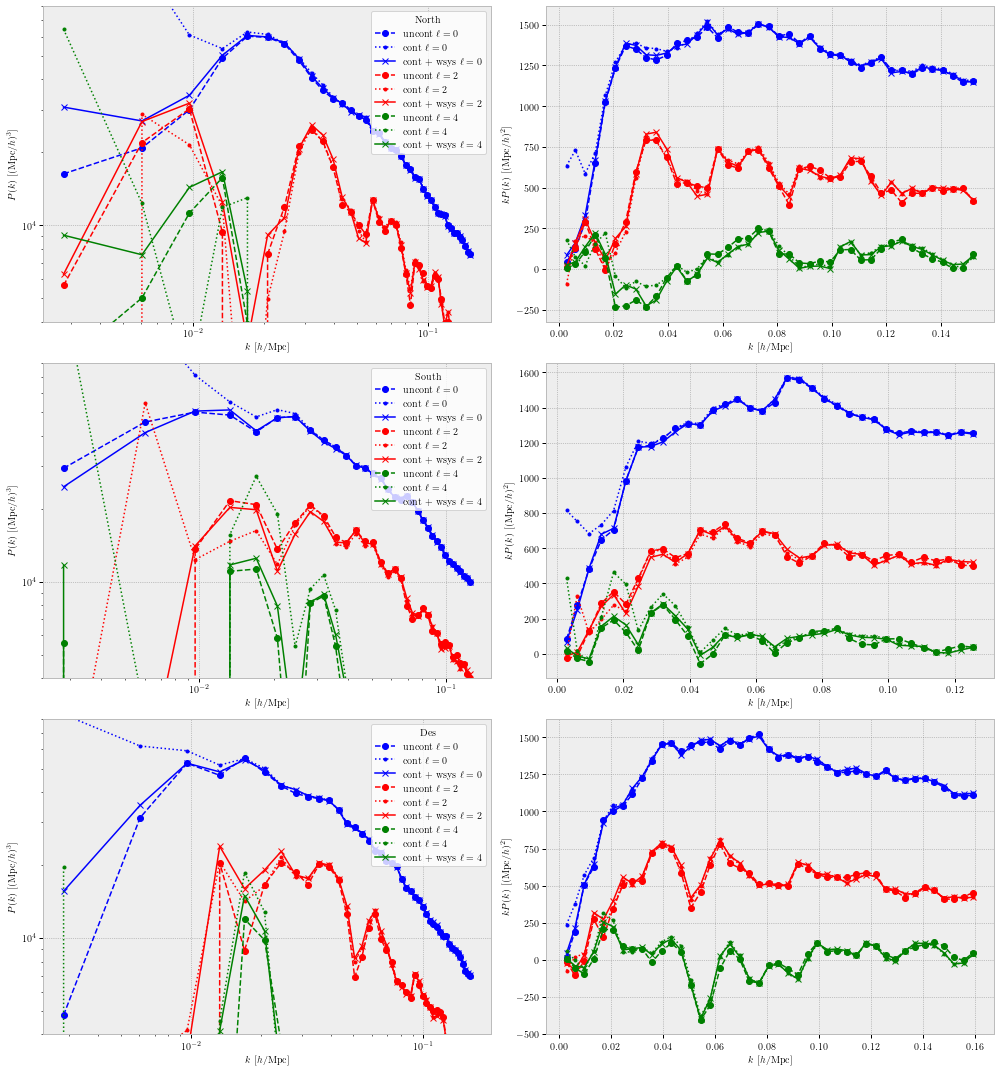

In [23]:
regions = ['North', 'South', 'Des']
z_min, z_max = 0.4, 0.6

plt.figure(figsize=(14, 15))
j = 0
for region in regions:
    sel_in_randoms = DR9(region)[randoms_pix_number] & (randoms['Z'] <= z_max) & (randoms['Z'] >= z_min) 
    sel_in_mock_uncont = DR9(region)[mock_uncont_pix_number] & (mock_uncont['Z'] <= z_max) & (mock_uncont['Z'] >= z_min) 
    sel_in_mock_cont = DR9(region)[mock_cont_pix_number] & (mock_cont['Z'] <= z_max) & (mock_cont['Z'] >= z_min) 

    k, poles = compute_power(mock_uncont[sel_in_mock_uncont], randoms[sel_in_randoms], return_plot=True)
    k2, poles2 = compute_power(mock_cont[sel_in_mock_cont], randoms[sel_in_randoms], return_plot=True)
    k3, poles3 = compute_power(mock_cont[sel_in_mock_cont], randoms[sel_in_randoms], data_weights=wsys_new(mock_cont[sel_in_mock_cont]['RA'], mock_cont[sel_in_mock_cont]['DEC']),  return_plot=True)

    plt.subplot(321+j)
    j += 1
    print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[i], ls='--', label='uncont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='.', color=color[i], ls=':', label='cont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='-', label='cont + wsys $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(4e3, 8e4)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')

    plt.subplot(321+j)
    j+=1
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, k*poles(ell=ell, complex=False), marker='o', color=color[i], ls='--', label='uncont $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles2(ell=ell, complex=False), marker='.', color=color[i], ls=':', label='cont $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles3(ell=ell, complex=False), marker='x', color=color[i], ls='-', label='cont + wsys $\ell = {:d}$'.format(ell))
    #plt.legend()
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.tight_layout()
plt.savefig('Mock_LRG_power.pdf')
plt.show()

#print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
#print('Normalization is {:.4f}.'.format(poles.wnorm))

[011573.46] 22-04-26 06:20  Notebook             INFO     Use default edges: np.linspace(0, 0.3, 81)
[011574.37] 22-04-26 06:20  CatalogFFTPower      INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[10279.51640823 10279.51640823 10279.51640823], boxcenter=[-465.97287548  -12.14680165 1051.77512543], dtype=float64).
[011574.98] 22-04-26 06:20  CatalogMesh          INFO     Slab 0 ~ 4194304 / 799625.
[011575.64] 22-04-26 06:20  CatalogMesh          INFO     Painted 799625 out of 799625 objects to mesh.
[011575.65] 22-04-26 06:20  CatalogMesh          INFO     Slab 0 ~ 4194304 / 794925.
[011576.27] 22-04-26 06:20  CatalogMesh          INFO     Painted 794925 out of 794925 objects to mesh.
[011576.27] 22-04-26 06:20  CatalogMesh          INFO     Running interlacing at order 2.
[011580.89] 22-04-26 06:20  CatalogMesh          INFO     Slab 0 ~ 4194304 / 799625.
[011581.48] 22-04-26 06:20  CatalogMesh          INFO     Painted 799625 out of 799625 objects to mes

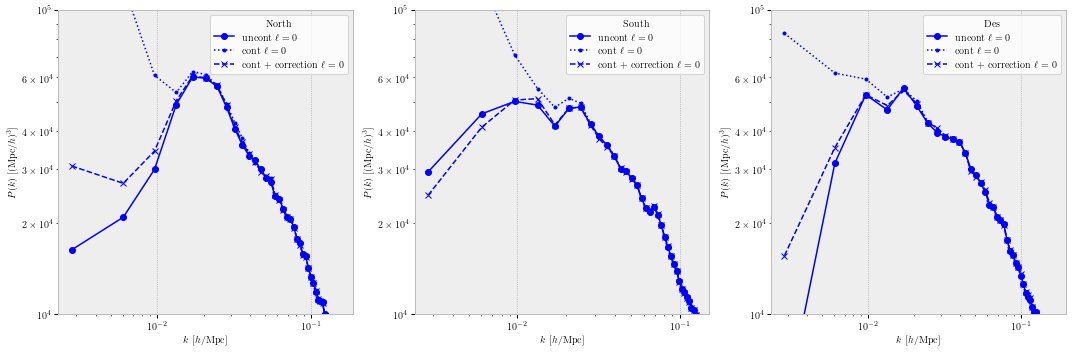

In [27]:
regions = ['North', 'South', 'Des']
z_min, z_max = 0.4, 0.6

plt.figure(figsize=(15, 5))
j = 0
for region in regions:
    sel_in_randoms = DR9(region)[randoms_pix_number] & (randoms['Z'] <= z_max) & (randoms['Z'] >= z_min) 
    sel_in_mock_uncont = DR9(region)[mock_uncont_pix_number] & (mock_uncont['Z'] <= z_max) & (mock_uncont['Z'] >= z_min) 
    sel_in_mock_cont = DR9(region)[mock_cont_pix_number] & (mock_cont['Z'] <= z_max) & (mock_cont['Z'] >= z_min) 

    k, poles = compute_power(mock_uncont[sel_in_mock_uncont], randoms[sel_in_randoms], ells=(0), return_plot=True)
    k2, poles2 = compute_power(mock_cont[sel_in_mock_cont], randoms[sel_in_randoms], ells=(0), return_plot=True)
    k3, poles3 = compute_power(mock_cont[sel_in_mock_cont], randoms[sel_in_randoms], ells=(0), data_weights=wsys_new(mock_cont[sel_in_mock_cont]['RA'], mock_cont[sel_in_mock_cont]['DEC']), return_plot=True)

    plt.subplot(131+j)
    j += 1
    print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[i], ls='-', label='uncont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='.', color=color[i], ls=':', label='cont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont + correction $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e4, 1e5)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')

plt.tight_layout()
plt.savefig('Mock_LRG_power_test.pdf')
plt.show()